# Homework

Get files for the tasks in Google drive: 
data_dictionary.txt
temp_data.csv
train.csv.zip
https://drive.google.com/drive/folders/1OPmtUZdoqT741tLGdB8oZPgL_stsnaEp?usp=share_link

<img style="float: left; height: 5.5em;" alt = "Book" src="https://m.media-amazon.com/images/I/51c1VrgvhVL.jpg">

Here, you are invited to resolve Data Analysis Tasks (each of 3 points).<br>
Please, find out helpful material, placed in the book Vanderplas, J. T. (2016). Python Data Science Handbook : Essential Tools for Working with Data; and the <a href="https://github.com/jakevdp/PythonDataScienceHandbook" target="_blank" rel="noopener noreferrer">notebooks for each chapter</a>.

## Linear Regression Analysis
Use `train.csv` dataset from [Sberbank Russian Housing Market](https://www.kaggle.com/c/sberbank-russian-housing-market/data) competition (you need to register on Kaggle in order to have an access to its datasets).

**Useful links**: [scikit-learn documentation](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning), [in depth: linear regression](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.06-Linear-Regression.ipynb).

---
**Task 3**. Using `train.csv` dataset (field's description in `data_dictionary.txt`), split it in two parts at random (use supporting code below) for `train_sample` (80% of observations) and `test_sample` (20% of observations). Perform two linear regression models for `price_doc` prediction for `train_sample` (use both numeric and categorical independent variables in your models).
```python
import pandas as pd
import zipfile

zf = zipfile.ZipFile('train.csv.zip') 
df = pd.read_csv(zf.open('train.csv'))

from sklearn.model_selection import train_test_split
train_sample, test_sample = train_test_split(df, test_size=0.2)
```

**Task 4**. Justify your choice and models' quality with supporting tests, charts and comments briefly.

**Task 5**. Assess the quality of your models on `test_sample` dataset. Use RMSE metric. Briefly describe whether or not this quality is appropriate.

In [18]:
import pandas as pd
import zipfile
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from subprocess import check_output

zf = zipfile.ZipFile('train.csv.zip') 
df = pd.read_csv(zf.open('train.csv'))


In [19]:
df=df.drop("id", axis='columns')
#Посмотрим, какие есть количественные переменные 
fl_df = df.select_dtypes(include=['float', 'int']).copy()
fl_df.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,6.407578e+06,...,9,4,0,13,22,1,0,52,4,5850000
1,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,9.589337e+06,...,15,3,0,15,29,1,10,66,14,6000000
2,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.808270e+06,...,10,3,0,11,27,0,4,67,10,5700000
3,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,1.258354e+07,...,11,2,1,4,4,0,0,26,3,13100000
4,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,8.398461e+06,...,319,108,17,135,236,2,91,195,14,16331452


In [3]:
# и какие качественные
obj_df = df.select_dtypes(include=['object']).copy()
obj_df.columns.values.tolist()
obj_df.head()

,timestamp,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology
0,2011-08-20,Investment,Bibirevo,no,no,no,no,no,no,no,no,no,no,no,no,good
1,2011-08-23,Investment,Nagatinskij Zaton,yes,no,no,no,no,no,no,no,no,no,no,no,excellent
2,2011-08-27,Investment,Tekstil'shhiki,no,no,no,no,yes,no,no,no,no,no,no,no,poor
3,2011-09-01,Investment,Mitino,no,no,no,no,no,no,no,no,no,no,no,no,good
4,2011-09-05,Investment,Basmannoe,no,no,no,no,yes,yes,no,no,no,no,no,yes,excellent


In [20]:
# Обработка категориальных переменных
# переменные с yes, no
cols = df.columns[df.dtypes.eq("object")]
df.loc[:, cols] = df[cols].replace({'yes': 1, 'no': 0})
# экология
ecology_map = {'poor': 1, 'satisfactory': 2, 'good': 3, 'excellent': 4, 'no data': np.NaN}
df['ecology'] = df['ecology'].apply(lambda x: ecology_map[x])
# В столбце product_type 33 значения NaN.
# Установим для них значение is_investment=1, так как это наиболее распространенное значение.
df['is_investment'] = df['product_type'].apply(
    lambda x: 0 if x == 'OwnerOccupier' else 1)
del df['product_type']

# Создадим категориальное значение для каждой подобласти
sub_areas = list(df['sub_area'].unique())
for area in sub_areas:
    df[area] = df['sub_area'].apply(lambda x: 1 if x == area else 0)
del df['sub_area']

column_names = df.columns.values.tolist()
NaN_columns = []
for i, col_name in enumerate(column_names):
    s = sum(pd.isnull(df.iloc[:,i]))
    if s > 0:
        NaN_columns.append(i)
# ... и установим для большинства из них медианное значение
for i in NaN_columns:
    if i in [2, 7, 8]: 
        continue
    else:
        df[column_names[i]]=df[column_names[i]].fillna(df[column_names[i]].median())

# Обновим значения NaN для life_sq, num_room и kitch_sq.
life_sq_to_full_sq = float(df['life_sq'].sum()) / \
    float(df.loc[df['life_sq'] > 0, 'full_sq'].sum())
average_room_size = float(df.loc[df['num_room'] > 0, 'full_sq'].sum()) / \
    float(df['num_room'].sum())
life_sq_to_kitch_sq = float(df['kitch_sq'].sum()) / \
    float(df.loc[df['kitch_sq'] > 0, 'full_sq'].sum())
df.loc[df['life_sq'].isnull(), 'life_sq'] = \
    df.loc[df['life_sq'].isnull(), 'full_sq'] * life_sq_to_full_sq
df.loc[df['num_room'].isnull(), 'num_room'] = \
    np.round(df.loc[df['num_room'].isnull(), 'full_sq'] / average_room_size)
df.loc[df['kitch_sq'].isnull(), 'kitch_sq'] = \
    df.loc[df['kitch_sq'].isnull(), 'full_sq'] * life_sq_to_kitch_sq

# Удалим выбросы из buildyear
median_build_year = df['build_year'].median()
df['build_year'] = df['build_year'].apply( \
    lambda x: median_build_year if x < 1800 else median_build_year if x > 2017 else x)


C:\Users\user\AppData\Local\Temp\ipykernel_16436\1743710420.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[area] = df['sub_area'].apply(lambda x: 1 if x == area else 0)
C:\Users\user\AppData\Local\Temp\ipykernel_16436\1743710420.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[area] = df['sub_area'].apply(lambda x: 1 if x == area else 0)
C:\Users\user\AppData\Local\Temp\ipykernel_16436\1743710420.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

C:\Users\user\AppData\Local\Temp\ipykernel_16436\1743710420.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[area] = df['sub_area'].apply(lambda x: 1 if x == area else 0)
C:\Users\user\AppData\Local\Temp\ipykernel_16436\1743710420.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[area] = df['sub_area'].apply(lambda x: 1 if x == area else 0)
C:\Users\user\AppData\Local\Temp\ipykernel_16436\1743710420.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

C:\Users\user\AppData\Local\Temp\ipykernel_16436\1743710420.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[area] = df['sub_area'].apply(lambda x: 1 if x == area else 0)
C:\Users\user\AppData\Local\Temp\ipykernel_16436\1743710420.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[area] = df['sub_area'].apply(lambda x: 1 if x == area else 0)
C:\Users\user\AppData\Local\Temp\ipykernel_16436\1743710420.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

C:\Users\user\AppData\Local\Temp\ipykernel_16436\1743710420.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[area] = df['sub_area'].apply(lambda x: 1 if x == area else 0)
C:\Users\user\AppData\Local\Temp\ipykernel_16436\1743710420.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[area] = df['sub_area'].apply(lambda x: 1 if x == area else 0)
C:\Users\user\AppData\Local\Temp\ipykernel_16436\1743710420.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

C:\Users\user\AppData\Local\Temp\ipykernel_16436\1743710420.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[area] = df['sub_area'].apply(lambda x: 1 if x == area else 0)
C:\Users\user\AppData\Local\Temp\ipykernel_16436\1743710420.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[area] = df['sub_area'].apply(lambda x: 1 if x == area else 0)
C:\Users\user\AppData\Local\Temp\ipykernel_16436\1743710420.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

In [21]:
# удалим пропущенные значения
df = df.dropna()
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,Poselenie Kokoshkino,Vostochnoe,Poselenie Krasnopahorskoe,Poselenie Novofedorovskoe,Poselenie Voronovskoe,Poselenie Klenovskoe,Poselenie Rogovskoe,Poselenie Kievskij,Molzhaninovskoe,Poselenie Mihajlovo-Jarcevskoe
0,2011-08-20,43,27.0,4.0,12.0,1.0,1979.0,2.0,5.449460,2.0,...,0,0,0,0,0,0,0,0,0,0
1,2011-08-23,34,19.0,3.0,12.0,1.0,1979.0,1.0,4.308875,2.0,...,0,0,0,0,0,0,0,0,0,0
2,2011-08-27,43,29.0,2.0,12.0,1.0,1979.0,2.0,5.449460,2.0,...,0,0,0,0,0,0,0,0,0,0
3,2011-09-01,89,50.0,9.0,12.0,1.0,1979.0,3.0,11.279115,2.0,...,0,0,0,0,0,0,0,0,0,0
4,2011-09-05,77,77.0,4.0,12.0,1.0,1979.0,3.0,9.758335,2.0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
time_group_d = df.set_index('timestamp').groupby(pd.Grouper(freq='D'))
time_group_w = df.set_index('timestamp').groupby(pd.Grouper(freq='W'))
time_group_m = df.set_index('timestamp').groupby(pd.Grouper(freq='M'))
time_group_d.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,Poselenie Kokoshkino,Vostochnoe,Poselenie Krasnopahorskoe,Poselenie Novofedorovskoe,Poselenie Voronovskoe,Poselenie Klenovskoe,Poselenie Rogovskoe,Poselenie Kievskij,Molzhaninovskoe,Poselenie Mihajlovo-Jarcevskoe
timestamp,,,,,,,,,,,,,,,,,,,,,
2011-08-20,43,27.000000,4.0,12.0,1.0,1979.0,2.0,5.449460,2.0,6.407578e+06,...,0,0,0,0,0,0,0,0,0,0
2011-08-23,34,19.000000,3.0,12.0,1.0,1979.0,1.0,4.308875,2.0,9.589337e+06,...,0,0,0,0,0,0,0,0,0,0
2011-08-27,43,29.000000,2.0,12.0,1.0,1979.0,2.0,5.449460,2.0,4.808270e+06,...,0,0,0,0,0,0,0,0,0,0
2011-09-01,89,50.000000,9.0,12.0,1.0,1979.0,3.0,11.279115,2.0,1.258354e+07,...,0,0,0,0,0,0,0,0,0,0
2011-09-05,77,77.000000,4.0,12.0,1.0,1979.0,3.0,9.758335,2.0,8.398461e+06,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-06-30,36,19.000000,5.0,16.0,1.0,1980.0,1.0,8.000000,3.0,6.050065e+06,...,0,0,0,0,0,0,0,0,0,0
2015-06-30,47,30.000000,23.0,25.0,4.0,2016.0,1.0,10.000000,1.0,9.629358e+06,...,0,0,0,0,0,0,0,0,0,0
2015-06-30,56,29.000000,13.0,14.0,1.0,2001.0,2.0,11.000000,3.0,9.249237e+06,...,0,0,0,0,0,0,0,0,0,0


In [7]:
time_group_d['price_doc'].head()

timestamp
2011-08-20     5850000
2011-08-23     6000000
2011-08-27     5700000
2011-09-01    13100000
2011-09-05    16331452
                ...   
2015-06-30     5000000
2015-06-30    10544070
2015-06-30    12000000
2015-06-30    10262010
2015-06-30     6750554
Name: price_doc, Length: 5621, dtype: int64

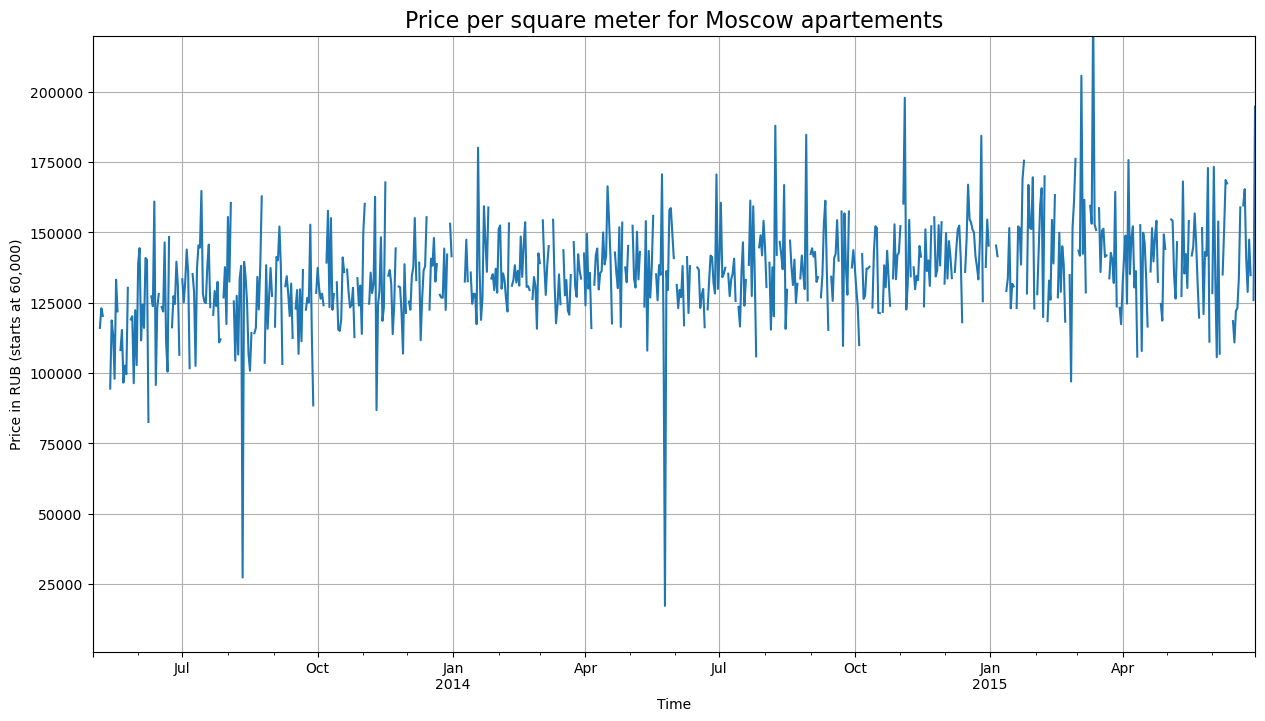

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,8))
(time_group_d['price_doc'].sum() / time_group_d['full_sq'].sum()).plot()
plt.title('Price per square meter for Moscow apartements', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Price in RUB (starts at 60,000)')
plt.ylim([1000,220000])
plt.xlim(['2013-05-01', '2015-06-30'])
plt.grid()

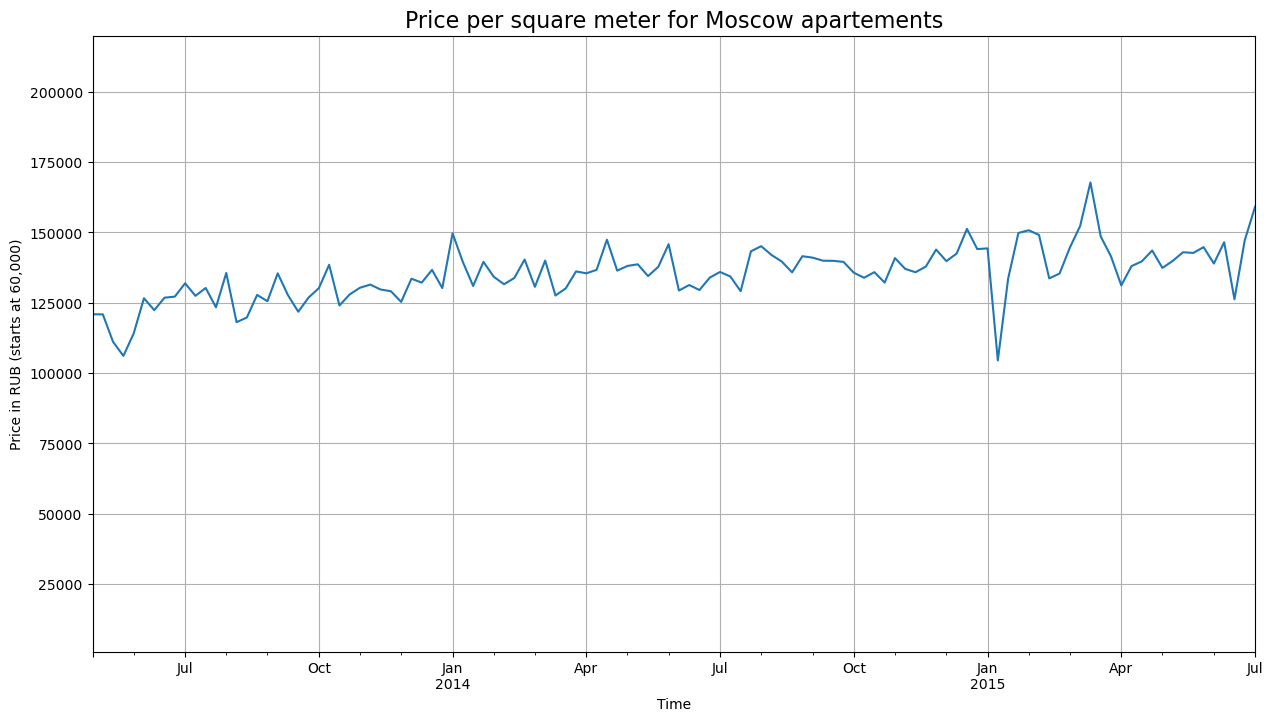

In [9]:
plt.figure(figsize=(15,8))
(time_group_w['price_doc'].sum() / time_group_w['full_sq'].sum()).plot()
plt.title('Price per square meter for Moscow apartements', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Price in RUB (starts at 60,000)')
plt.ylim([1000,220000])
plt.xlim(['2013-05-01', '2015-06-30'])
plt.grid()

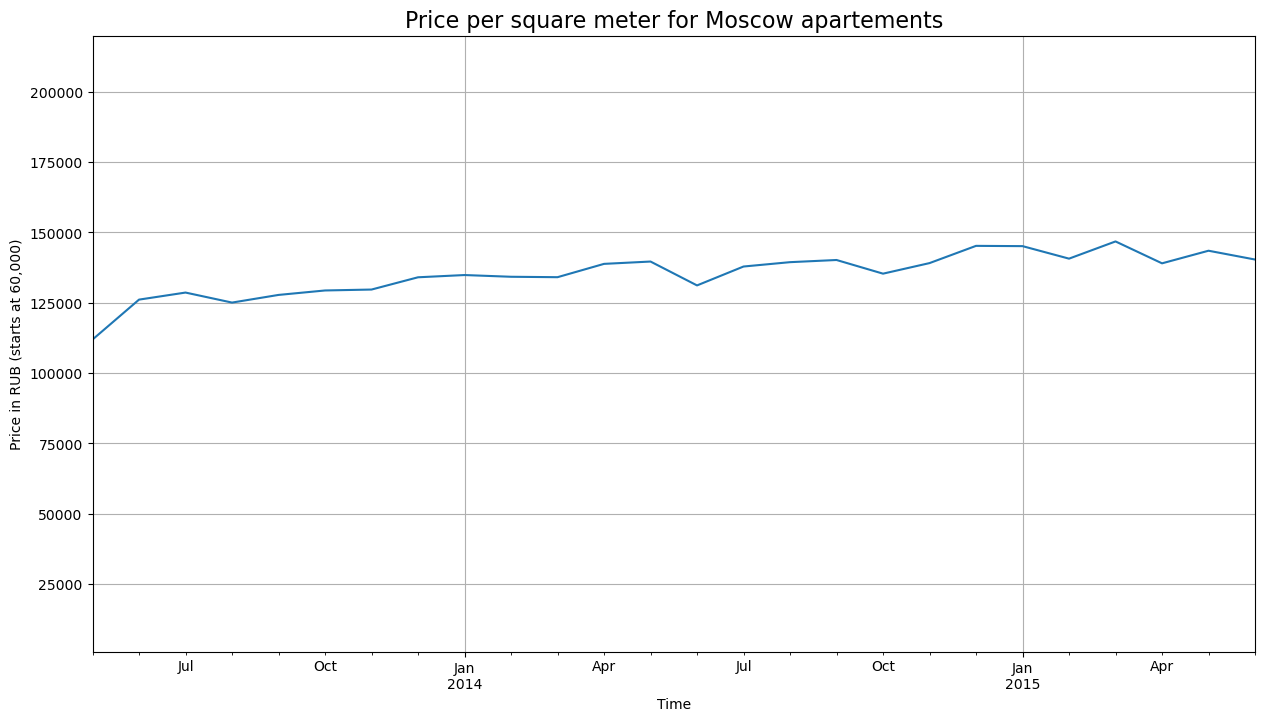

In [10]:
plt.figure(figsize=(15,8))
(time_group_m['price_doc'].sum() / time_group_m['full_sq'].sum()).plot()
plt.title('Price per square meter for Moscow apartements', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Price in RUB (starts at 60,000)')
plt.ylim([1000,220000])
plt.xlim(['2013-05-01', '2015-06-30'])
plt.grid()

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import *
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SequentialFeatureSelector
df=df.drop("timestamp", axis='columns')

In [23]:
import scipy.stats as stats
# удалим выбросы в данных количественных переменных
z = np.abs(stats.zscore(df.select_dtypes(include=['float64']))) # z-оценка для числовых переменных
df = df[(z<3).all(axis=1)]
df.shape

(17646, 435)

In [24]:
cor_matrix = df.corr().abs()
price_doc = df['price_doc']
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.4)]
df=df.drop(to_drop, axis='columns')
df['price_doc'] = price_doc
df.head()

C:\Users\user\AppData\Local\Temp\ipykernel_16436\2854299505.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


,full_sq,floor,max_floor,material,kitch_sq,state,area_m,raion_popul,school_education_centers_top_20_raion,hospital_beds_raion,...,Vostochnoe,Poselenie Krasnopahorskoe,Poselenie Novofedorovskoe,Poselenie Voronovskoe,Poselenie Klenovskoe,Poselenie Rogovskoe,Poselenie Kievskij,Molzhaninovskoe,Poselenie Mihajlovo-Jarcevskoe,price_doc
0,43,4.0,12.0,1.0,5.449460,2.0,6.407578e+06,155572,0,240.0,...,0,0,0,0,0,0,0,0,0,5850000
2,43,2.0,12.0,1.0,5.449460,2.0,4.808270e+06,101708,0,1183.0,...,0,0,0,0,0,0,0,0,0,5700000
3,89,9.0,12.0,1.0,11.279115,2.0,1.258354e+07,178473,0,990.0,...,0,0,0,0,0,0,0,0,0,13100000
7,44,5.0,12.0,1.0,5.576192,2.0,6.407578e+06,155572,0,240.0,...,0,0,0,0,0,0,0,0,0,2000000
8,42,5.0,12.0,1.0,5.322728,2.0,4.787424e+06,96959,0,1894.0,...,0,0,0,0,0,0,0,0,0,5300000


In [25]:
#Посмотрим, какие есть количественные переменные 
fl_df = df.select_dtypes(include=['float', 'int']).copy()


In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Применение нормализации ко всем числовым столбцам
num_vars = fl_df.columns.values.tolist()
df[num_vars] = scaler.fit_transform(df[num_vars])
df['price_doc'] = price_doc

df_train, df_test = train_test_split(df, test_size=0.2)


In [27]:
y_train = df_train.pop('price_doc')
X_train = df_train
y_test = df_test.pop('price_doc')
X_test = df_test

In [28]:
df_train, df_test = train_test_split(df, test_size=0.2)
y_train = df_train.pop('price_doc')
X_train = df_train
y_test = df_test.pop('price_doc')
X_test = df_test
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_train, y_train)
importance = np.abs(ridge.coef_)
colnames = list(X_train.columns)
feature_names = np.array(colnames)
np.random.seed(128)
sfs_backward = SequentialFeatureSelector(
    ridge, n_features_to_select=5, direction="forward"
).fit(X_train, y_train)

print(
    "Выбраны переменные по методу forward sequential selection: "
    f"{feature_names[sfs_backward.get_support()]}")

Выбраны переменные по методу forward sequential selection: ['full_sq' 'state' 'area_m' 'raion_popul' 'university_top_20_raion']


In [29]:
np.random.seed(128)
df_train, df_test = train_test_split(df[['price_doc','full_sq', 'state', 'area_m', 'raion_popul', 'university_top_20_raion']], train_size = 0.8, test_size = 0.2, random_state = 100)

y_train = df_train['price_doc']
X_train = df_train.drop("price_doc", axis='columns')
lm = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(estimator=lm, n_features_to_select=9)
rfe = rfe.fit(X_train, y_train)
X_train_rfe = X_train[X_train.columns[rfe.support_]]
def build_model(X,y):
    X = sm.add_constant(X) #Добавить константу
    lm = sm.OLS(y,X).fit() # подгонка модели
    print(lm.summary()) # оценка модели
    return X

def checkVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

X_train_new = build_model(X_train_rfe,y_train)

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     2652.
Date:                Fri, 23 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:03:29   Log-Likelihood:            -2.3131e+05
No. Observations:               14116   AIC:                         4.626e+05
Df Residuals:                   14110   BIC:                         4.627e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -1

In [30]:
# R2 коэффициен детерминации показывает скорее о плохой обусловленности модели
# удалим переменные с наименьшим эффектом и пересчитаем 
df_train, df_test = train_test_split(df[['price_doc','full_sq', 'area_m', 'university_top_20_raion']], train_size = 0.7, test_size = 0.3, random_state = 100)

y_train = df_train['price_doc']
X_train = df_train.drop("price_doc", axis='columns')
lm = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(estimator=lm, n_features_to_select=9)
rfe = rfe.fit(X_train, y_train)
X_train_rfe = X_train[X_train.columns[rfe.support_]]

X_train_new = build_model(X_train_rfe,y_train)

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     3405.
Date:                Fri, 23 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:03:34   Log-Likelihood:            -2.0271e+05
No. Observations:               12352   AIC:                         4.054e+05
Df Residuals:                   12348   BIC:                         4.055e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1

В результате R2 даже немного уменьшился. Посмотрим на другие метрики итоговой модели.

In [31]:
checkVIF(X_train_new) # коллинеарность отсутствует

,Features,VIF
0,const,8.74
1,full_sq,1.03
2,area_m,1.03
3,university_top_20_raion,1.02


C:\Users\user\AppData\Local\Temp\ipykernel_16436\1450746972.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_train - y_train_price), bins = 20)


Text(0.5, 0, 'Errors')

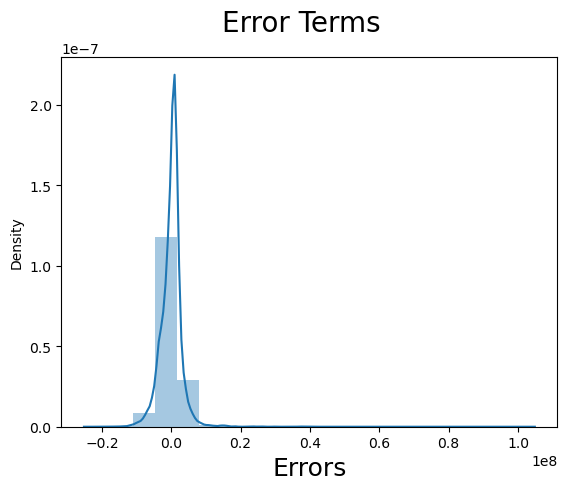

In [33]:
import seaborn as sns
lm = sm.OLS(y_train,X_train_new).fit()
y_train_price = lm.predict(X_train_new)
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)
plt.xlabel('Errors', fontsize = 18) 
# большая плотность ошибок распределена по нормальному закону, однако есть выбросы в ошибках, что вероятно и является 
# причиной плохой обусловленности модели

Text(0, 0.5, 'y_pred')

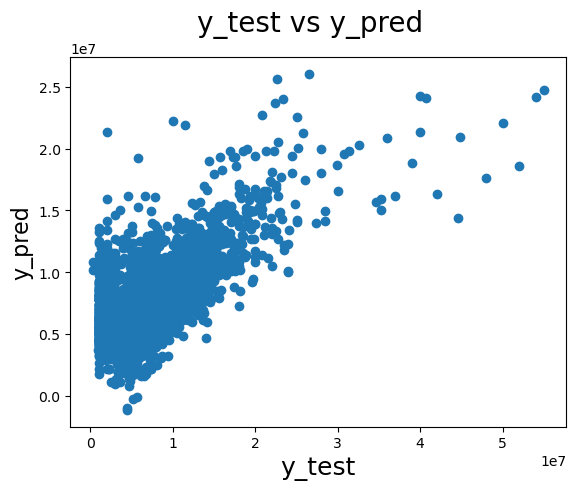

In [34]:
y_test = df_test['price_doc']
X_test = df_test.drop("price_doc", axis='columns')
X_train_new = X_train_new.drop('const',axis=1)
X_test_new = X_test[X_train_new.columns]
X_test_new = sm.add_constant(X_test_new)
y_pred = lm.predict(X_test_new)
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)            
plt.xlabel('y_test', fontsize=18)                         
plt.ylabel('y_pred', fontsize=16) 
# на графике мы можем визуально увидеть, в какую сторону отклоняются ошибки:
# это данные для цены более 27 миллионов. Прогнозные данные не чувствительны к таким ценам

In [35]:
df=df.query("`price_doc` < 27000000")
df_train, df_test = train_test_split(df, test_size=0.2)
y_train = df_train.pop('price_doc')
X_train = df_train
y_test = df_test.pop('price_doc')
X_test = df_test
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_train, y_train)
importance = np.abs(ridge.coef_)
colnames = list(X_train.columns)
feature_names = np.array(colnames)
np.random.seed(128)
sfs_backward = SequentialFeatureSelector(
    ridge, n_features_to_select=5, direction="forward"
).fit(X_train, y_train)

print(
    "Выбраны переменные по методу forward sequential selection: "
    f"{feature_names[sfs_backward.get_support()]}")

Выбраны переменные по методу forward sequential selection: ['full_sq' 'state' 'area_m' 'raion_popul' 'university_top_20_raion']


In [36]:
df_train, df_test = train_test_split(df[['price_doc','full_sq', 'state', 'area_m', 
                                         'raion_popul', 'university_top_20_raion']], 
                                          train_size = 0.8, test_size = 0.2, random_state = 100)

y_train = df_train['price_doc']
X_train = df_train.drop("price_doc", axis='columns')
lm = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(estimator=lm, n_features_to_select=9)
rfe = rfe.fit(X_train, y_train)
X_train_rfe = X_train[X_train.columns[rfe.support_]]

X_train_new = build_model(X_train_rfe,y_train)

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     2433.
Date:                Fri, 23 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:06:16   Log-Likelihood:            -2.2781e+05
No. Observations:               14045   AIC:                         4.556e+05
Df Residuals:                   14039   BIC:                         4.557e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -7

C:\Users\user\AppData\Local\Temp\ipykernel_16436\2837074538.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_train - y_train_price), bins = 20)


Text(0.5, 0, 'Errors')

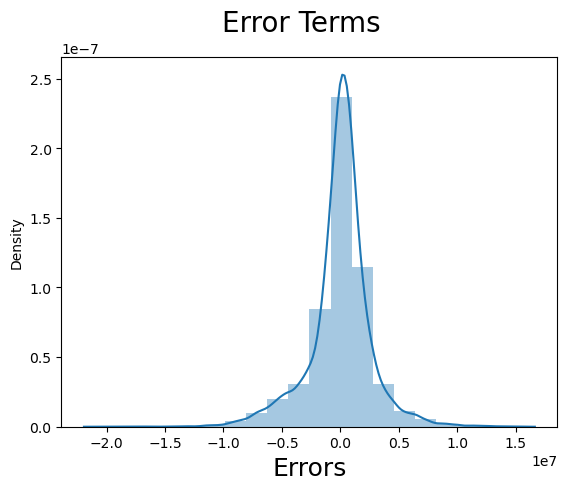

In [37]:
lm = sm.OLS(y_train,X_train_new).fit()
y_train_price = lm.predict(X_train_new)
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)
plt.xlabel('Errors', fontsize = 18) 
# сейчас ошибки распределены более нормально, однако тем-не менее сохранилась ассимметрия в меньшую сторону.

Text(0, 0.5, 'y_pred')

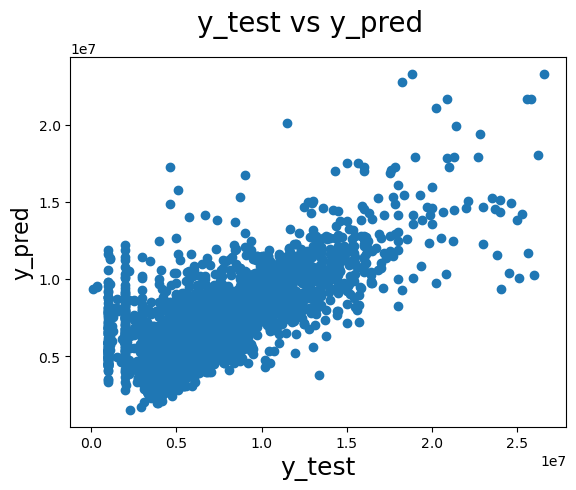

In [38]:
y_test = df_test['price_doc']
X_test = df_test.drop("price_doc", axis='columns')
X_train_new = X_train_new.drop('const',axis=1)
X_test_new = X_test[X_train_new.columns]
X_test_new = sm.add_constant(X_test_new)
y_pred = lm.predict(X_test_new)
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)            
plt.xlabel('y_test', fontsize=18)                         
plt.ylabel('y_pred', fontsize=16) 
# на графике мы можем визуально увидеть, что ошибки распределены более линейно по сравнению с предыдущим.

In [39]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(y_test, y_pred, squared=False)
rms # однако выбросы всё-так же сохранились, только в меньшую сторону, поэтому показатель rmse на столько высокий. Кроме того,
# он высокий ещё и потому, что абсолютные величины сами по себе имеют большой разброс. 

2634181.743759083

## K-Nearest Neighbors Analysis
Use any financial ticker (except S&P500) to create the trading strategy, using KNN classifier.

**Hint**. Use [this material](https://blog.quantinsti.com/machine-learning-k-nearest-neighbors-knn-algorithm-python/) to start your own calculations. [This link](https://pypi.org/project/fix-yahoo-finance/0.1.30/) with library fixes might be helpful.

**Useful link**: [scikit-learn documentation](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).

---
**Task 6**. Upload data for one ticker (for the recent year) from Yahoo Finance. Make brief exploratory analysis of obtained data.

**Task 7**. Apply KNN classifier to obtained data. Assess the quality of the model. Create and briefly justify the trading strategy.

In [ ]:
!pip install pandas-datareader
!pip install fix-yahoo-finance==0.1.30
!pip install yfinance

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from pandas_datareader import data as pdr
import yfinance as yf
from pandas.plotting import register_matplotlib_converters
msft = yf.Ticker("MSFT") # импорт данных по тикеру майкрософт
msft.info
hist = msft.history(period="1y")

In [41]:
# построим модель
df = hist.dropna()
df = df[['Open', 'High', 'Low','Close', 'Volume']] # оставим значимые переменные
# определим предикторы
df['Open-Close']= df.Open -df.Close
df['High-Low']  = df.High - df.Low
df =df.dropna()
X= df[['Open-Close', 'High-Low', 'Volume']]
# Целевая переменная
Y= np.where(df['Close'].shift(-5)>df['Close'],1,-1) # определим сдвиг на 5 дней - то есть торговая неделя
# Итак, стратегия заключается в том, чтобы на основании разницы цен открытия-закрытия, минимума-максимума и объема торгов за день,
# совершить покупку (1) или продажу (-1), чтобы затем закрыть сделку через 5 дней - т.е. торговую неделю
# Разделение датасета
split_percentage = 0.7
split = int(split_percentage*len(df))

X_train = X[:split]
Y_train = Y[:split]

X_test = X[split:]
Y_test = Y[split:]

# Инициация модели (путем подбора выбрана оптимальная k=9)
knn = KNeighborsClassifier(n_neighbors=9)

knn.fit(X_train, Y_train)

accuracy_train = accuracy_score(Y_train, knn.predict(X_train))
accuracy_test = accuracy_score(Y_test, knn.predict(X_test))

print ('Тренировочные данные. Точность: %.2f' %accuracy_train)
print ('Тестовые данные. Точность: %.2f' %accuracy_test)

Тренировочные данные. Точность: 0.62
Тестовые данные. Точность: 0.61


C:\Users\user\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\user\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

C:\Users\user\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


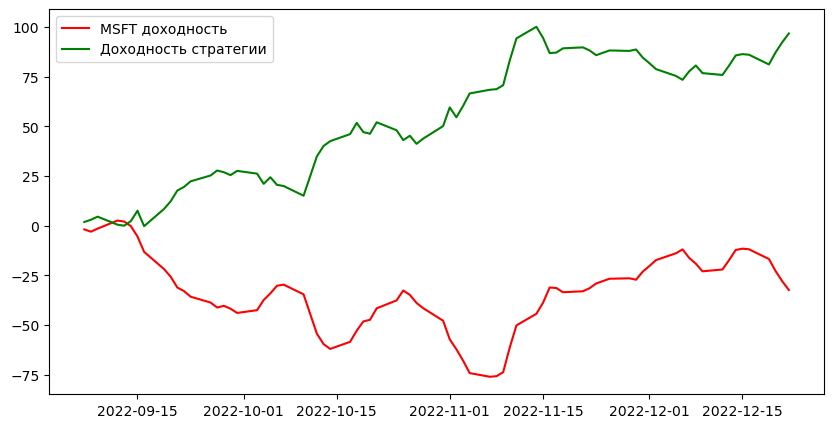

In [43]:
# Создание стратегии покупки-продажи
df['Predicted_Signal'] = knn.predict(X)

df['MSFT_returns'] = np.log(df['Close']/df['Close'].shift(5)) # если бы мы просто покупали и продавали каждые 5 дней
Cumulative_MSFT_returns = df[split:]['MSFT_returns'].cumsum()*100
df['Startegy_returns'] = df['MSFT_returns']* df['Predicted_Signal'].shift(5) # если бы покупали и продавали по сигналу и закрывали сделку через 5 дней
Cumulative_Strategy_returns = df[split:]['Startegy_returns'].cumsum()*100

# визуализация доходности тикера и стратегии

plt.figure(figsize=(10,5))
plt.plot(Cumulative_MSFT_returns, color='r',label = 'MSFT доходность')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Доходность стратегии')
plt.legend()
plt.show()

In [44]:
# Посчитаем критерий Шарпа для - коэффициент доходности сверх рыночной доходности
Std = Cumulative_Strategy_returns.std()
Sharpe = (Cumulative_Strategy_returns-Cumulative_MSFT_returns)/Std
Sharpe = Sharpe.mean()
print('Коэффициент Шарпа: %.2f'%Sharpe )
# Итак, можно заключить, что данная стратегия обеспечивает доходность лучше рынка в 2,78 раза.

Коэффициент Шарпа: 2.78


## Decision Trees Analysis
**Hint**. Use [this material](https://blog.quantinsti.com/decision-tree/) to start your own calculations.

**Useful link**: [decision trees and random forests](https://github.com/jakevdp/PythonDataScienceHandbook/blob/8a34a4f653bdbdc01415a94dc20d4e9b97438965/notebooks/05.08-Random-Forests.ipynb).

---
**Task 8**. Upload data for one ticker (for the recent year) from Quandl. Make brief exploratory analysis of obtained data.

**Task 9**. Apply Decision Tree to obtained data. Assess the quality of the model. Create and briefly justify the trading strategy.

In [40]:
!pip install quandl

     -------------------------------------- 52.8/52.8 kB 545.8 kB/s eta 0:00:00


In [48]:
import quandl
df = quandl.get("WIKI/TSLA", start_date='2017-03-27', end_date='2018-03-27', collapse="daily") # последний доступный год этого набора данных
df=df[['Open', 'Close', 'High', 'Low', 'Volume']] # оставляем не дублирующиеся переменные

In [81]:
!jupyter nbextension enable --py widgetsnbextension
from pandas_profiling import ProfileReport
report = ProfileReport(df, title="Обзор данных", sort="ascending")
report.to_file("TSLA_report.html")
report

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [89]:
df['Return'] = df['Close'].pct_change(1).shift(-5) # возвращает изменение по сравнению с ценой закрытия через 5 дней
df['target_cls'] = np.where(df.Return > 0, 1, -1) # создаём таргет-переменную
df.head(15)

,Open,Close,High,Low,Volume,Return,target_cls,y_pred,TSLA_returns,Startegy_returns
Date,,,,,,,,,,
2017-03-27,260.60,270.22,270.5700,259.7500,6230795.0,0.072655,1,1,-0.026404,-0.026404
2017-03-28,277.02,277.45,280.6800,275.0000,7987604.0,0.017352,1,1,0.000252,0.000252
2017-03-29,278.34,277.38,279.6000,275.5400,3676157.0,-0.028647,-1,1,-0.001945,-0.001945
2017-03-30,278.04,277.92,282.0000,277.2100,4148426.0,0.012542,1,1,-0.001366,-0.001366
2017-03-31,278.73,278.30,279.6800,276.3197,3294640.0,0.012856,1,1,-0.070137,-0.070137
2017-04-03,286.90,298.52,299.0000,284.5800,13888618.0,0.032558,1,1,-0.017203,-0.017203
2017-04-04,296.89,303.70,304.8100,294.5300,10134556.0,-0.011780,-1,1,0.029065,0.029065
2017-04-05,302.04,295.00,304.8800,294.2000,7880938.0,-0.038450,-1,1,-0.012464,-0.012464
2017-04-06,296.88,298.70,301.9400,294.1000,5520588.0,0.024121,1,1,-0.012774,-0.012774


In [90]:
predictors_list = ['Open', 'Close', 'High', 'Low', 'Volume']
X = df[predictors_list]
X.shape

(252, 5)

In [91]:
y_cls = df.target_cls
y_cls.shape

(252,)

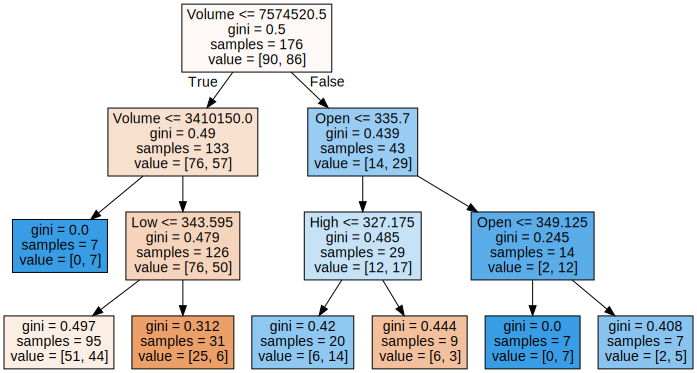

In [92]:
y=y_cls
X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(X, y_cls, test_size=0.3, random_state=432, stratify=y)

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=6)

clf = clf.fit(X_cls_train, y_cls_train)

from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None,filled=True,feature_names=predictors_list)
graphviz.Source(dot_data) # визуализируем дерево

In [93]:
y_cls_pred = clf.predict(X_cls_test)
from sklearn.metrics import classification_report
report = classification_report(y_cls_test, y_cls_pred)
print(report) # отчёт о точности модели - говорит о том, что модель чуть лучше, чем ничего

              precision    recall  f1-score   support

          -1       0.48      0.74      0.59        39
           1       0.38      0.16      0.23        37

    accuracy                           0.46        76
   macro avg       0.43      0.45      0.41        76
weighted avg       0.43      0.46      0.41        76



In [94]:
df['y_pred'] = clf.predict(X) # поместим предсказанный таргет в датафрейм
df.tail()

,Open,Close,High,Low,Volume,Return,target_cls,y_pred,TSLA_returns,Startegy_returns
Date,,,,,,,,,,
2018-03-21,310.25,316.53,322.44,310.19,5927881.0,NaN,-1,-1,0.023753,-0.023753
2018-03-22,313.89,309.10,318.82,308.18,4914307.0,NaN,-1,-1,0.024762,0.024762
2018-03-23,311.25,301.54,311.61,300.45,6600538.0,NaN,-1,-1,-0.008717,0.008717
2018-03-26,307.34,304.18,307.59,291.36,8324639.0,NaN,-1,1,0.085763,0.085763
2018-03-27,304.00,279.18,304.27,277.18,13696168.0,NaN,-1,1,NaN,NaN


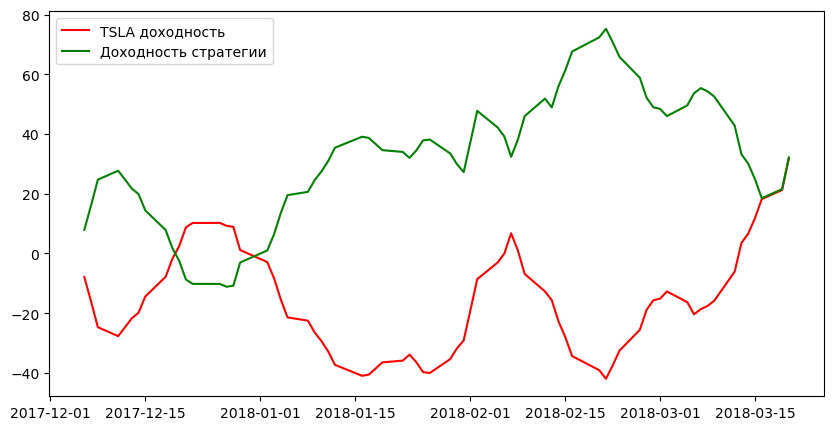

In [98]:
# Таким образом, наша стратегия: покупать, когда предсказанная через 5 дней выше сегодняшней и продавать, когда ниже.
df['TSLA_returns'] = np.log(df['Close']/df['Close'].shift(-5))
Cumulative_TSLA_returns = df[split:]['TSLA_returns'].cumsum()*100
df['Startegy_returns'] = df['TSLA_returns']* df['y_pred'].shift(-5) # если бы покупали и продавали по сигналу
Cumulative_Strategy_returns = df[split:]['Startegy_returns'].cumsum()*100
plt.figure(figsize=(10,5))
plt.plot(Cumulative_MSFT_returns, color='r',label = 'TSLA доходность')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Доходность стратегии')
plt.legend()
plt.show()

### В конечном счёте, если в точности следовать этой стратегии, будет такая же доходность, как и у акций. Поэтому стратгеия требуется в доработке. 